In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sns
import copy

from load_data import load_expression, load_dataset
from model import SpiceMix
from Result import SpiceMixResult

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: flex;
    justify-content: center;
}
</style>
""")

In [3]:
import h5py

In [4]:
with h5py.File("../../data/aggregate_separate_fovs/results_with_spatial.hdf5", 'r') as h5file:
    print(h5file["weights"]["0"].keys())

<KeysViewHDF5 ['0', '10', '100', '110', '120', '130', '140', '150', '160', '170', '180', '190', '20', '200', '210', '220', '230', '240', '250', '260', '270', '30', '40', '50', '60', '70', '80', '90']>


In [5]:
cardiac_development_spatial_result = SpiceMixResult(
    path2dataset='../../data/aggregate_separate_fovs',
    result_filename="../../data/aggregate_separate_fovs/results_with_spatial.hdf5",
    neighbor_suffix="",
)

cardiac_development_nmf_result = SpiceMixResult(
    path2dataset='../../data/aggregate_separate_fovs',
    result_filename="../../data/aggregate_separate_fovs/results_no_spatial.hdf5",
    neighbor_suffix="",
)

Result file = ../../data/aggregate_separate_fovs/results_with_spatial.hdf5


/work/magroup/shahula/spatiotemporal_cardiac/spicemix_test/SpiceMix/SpiceMix/util.py:112: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value


Result file = ../../data/aggregate_separate_fovs/results_no_spatial.hdf5


Found 269 iterations from ../../data/aggregate_separate_fovs/results_with_spatial.hdf5
Found 308 iterations from ../../data/aggregate_separate_fovs/results_no_spatial.hdf5


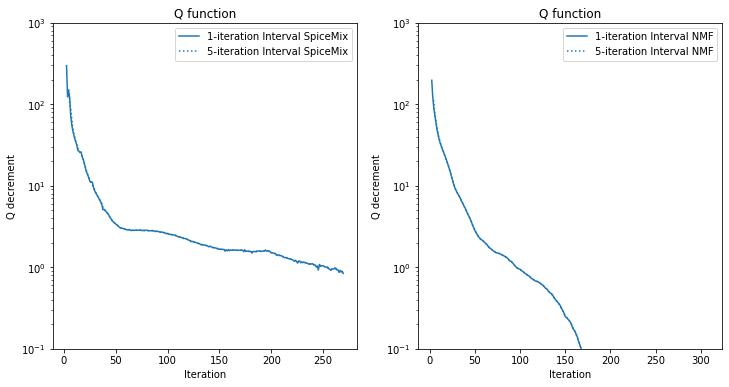

In [6]:
# Prior to downstream analysis, we should make sure the models have converged
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
cardiac_development_spatial_result.plot_convergence(axes[0], label='SpiceMix', c='C0')
cardiac_development_nmf_result.plot_convergence(axes[1], label='NMF', c='C0')
for ax in axes.flat:
    ax.set_title('Q function')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Q decrement')
    ax.set_yscale('log')
    ax.set_ylim(10**-1, 10**3)
    ax.legend()

In [7]:
# Load latent states for all cells estimated by the last iteration of SpiceMix/NMF
cardiac_development_spatial_result.load_latent_states(iiter=-1)
cardiac_development_nmf_result.load_latent_states(iiter=-1)

Iteration -1


/work/magroup/shahula/spatiotemporal_cardiac/spicemix_test/SpiceMix/SpiceMix/util.py:112: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value


Iteration -1


optimal K = 7
#clusters = 7, #-1 = 0
optimal K = 10
#clusters = 10, #-1 = 0


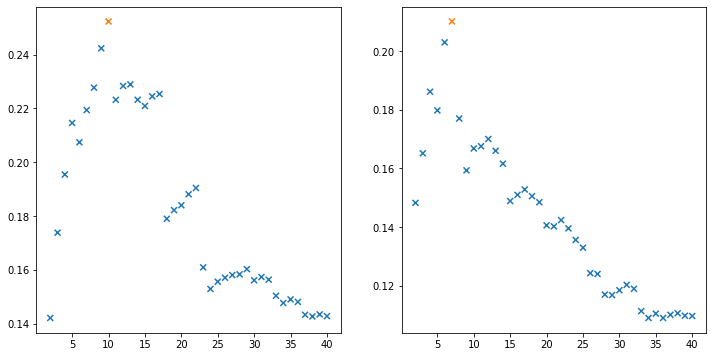

In [8]:
# Do hierarchical clustering on ALL cells in the latent space
# TODO: accelerate this function for datasets of 10k+ cells 
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
cardiac_development_nmf_result.determine_optimal_clusters(axes[1], K_range=np.arange(2, 41))
cardiac_development_spatial_result.determine_optimal_clusters(axes[0], K_range=np.arange(2, 41))

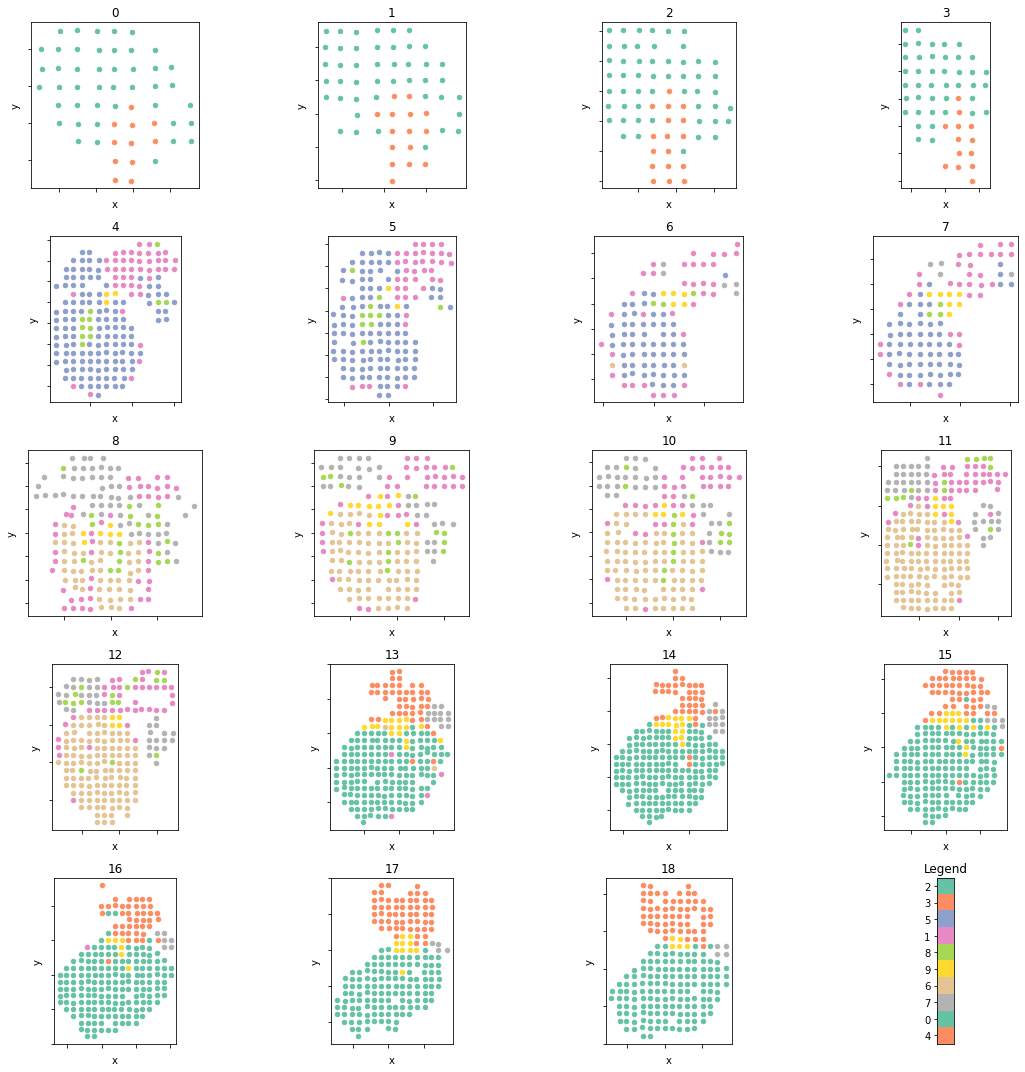

In [9]:
plot_height = int(np.sqrt(cardiac_development_spatial_result.num_repli))
plot_width = cardiac_development_spatial_result.num_repli // plot_height

if plot_height * plot_width < cardiac_development_spatial_result.num_repli:
    plot_width += 1

fig, axes = plt.subplots(plot_width, plot_height, figsize=(plot_height * 4, plot_width * 3))
cardiac_development_spatial_result.plot_multireplicate(axes, "cluster")

In [10]:
replicate = "18"

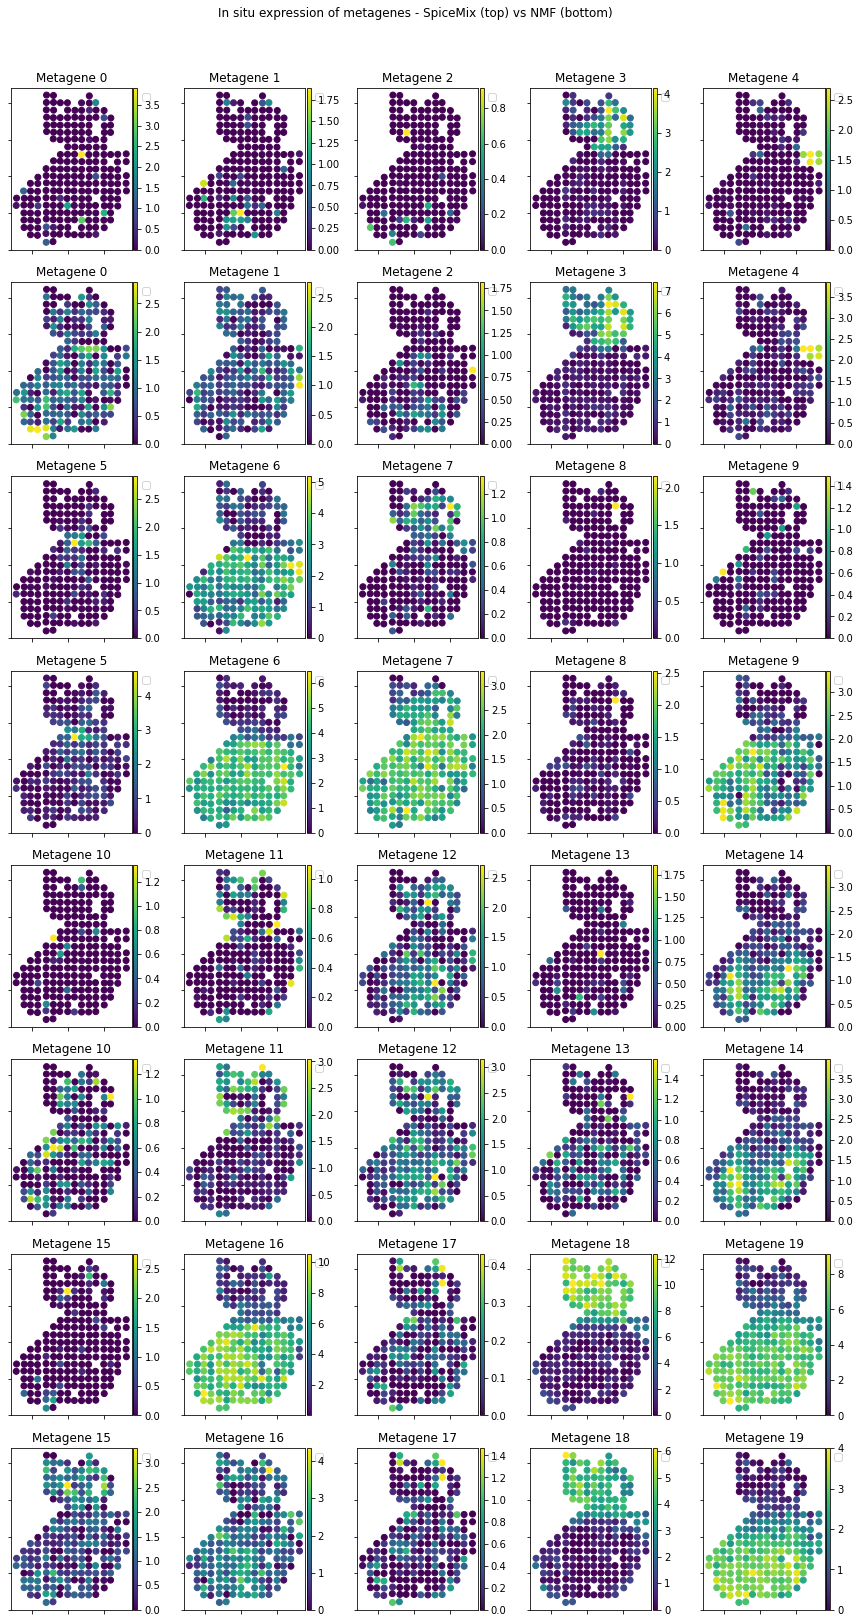

In [11]:
# We ovrlap latent states on the spatial space
# SpiceMix metagenes are expected to show clearer spatial patterns with less background expressions
segmentdata = copy.deepcopy(plt.get_cmap('Reds')._segmentdata)
segmentdata['red'  ][0] = (0., 1., 1.)
segmentdata['green'][0] = (0., 1., 1.)
segmentdata['blue' ][0] = (0., 1., 1.)
cmap = LinearSegmentedColormap('', segmentdata=segmentdata, N=256)

plot_height = 8
plot_width = 5
fig, axes = plt.subplots(plot_height, plot_width, figsize=(plot_width * 3, plot_height * 3.5))
fig.suptitle('In situ expression of metagenes - SpiceMix (top) vs NMF (bottom)', y=.92)
cardiac_development_spatial_result.plot_metagenes(axes[[0, 2, 4, 6]], s=1, cmap=cmap, replicate=replicate)
cardiac_development_nmf_result.plot_metagenes(axes[[1, 3, 5, 7]], s=1, cmap=cmap, replicate=replicate)
plt.show()

# Comparing to SpatialDE AEH Results

In [12]:
# Three available timepoints: 5 weeks, 6 weeks, and 9 weeks
timepoint = 9
# Point in space
sample = 5

In [13]:
histology_results = pd.read_csv(f"../../../spatial_de_test/results/{timepoint}/histology_results_{sample}.tsv", sep="\t", index_col=0)
patterns = pd.read_csv(f"../../../spatial_de_test/results/{timepoint}/patterns_{sample}.tsv", sep="\t", index_col=0)
coordinates = pd.read_csv(f"../../../spatial_de_test/results/{timepoint}/coordinates_{sample}.tsv", sep="\t", index_col=0)

In [14]:
valid_patterns = np.unique(histology_results["pattern"].values)

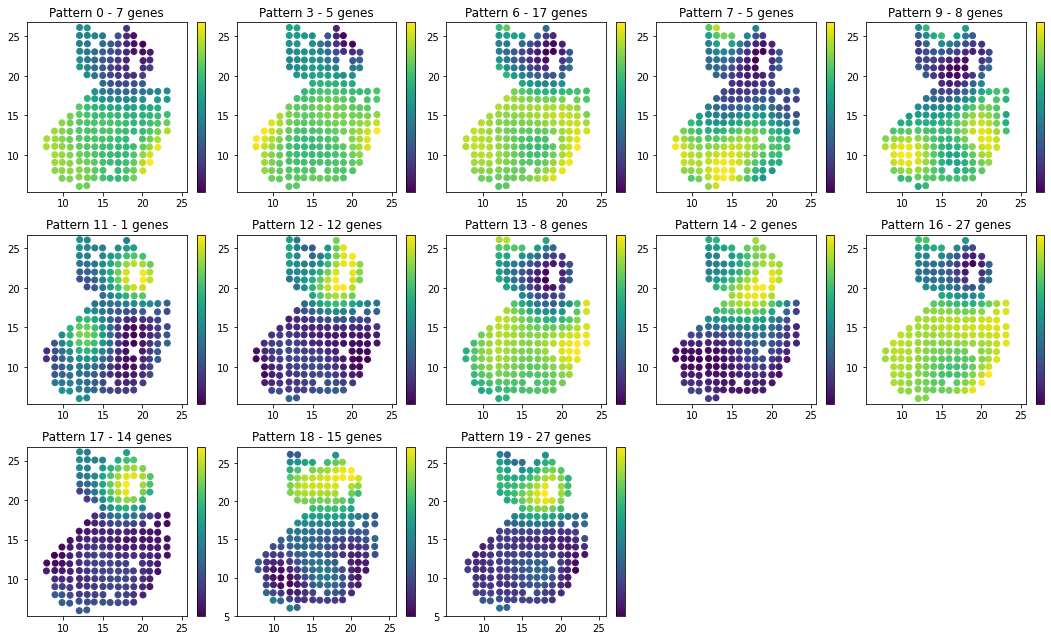

In [15]:
plot_height = np.sqrt(len(valid_patterns)).astype(int)
plot_width = len(valid_patterns) // plot_height + 1
plt.figure(figsize=(plot_width * 3, plot_height * 3))
for index, pattern in enumerate(valid_patterns):
    pattern_string = str(pattern)
    
    plt.subplot(plot_height, plot_width, index + 1)
    plt.scatter(coordinates['new_x'], coordinates['new_y'], c=patterns[pattern_string]);
    plt.axis('equal')
    plt.title('Pattern {} - {} genes'.format(pattern, histology_results.query('pattern == @pattern').shape[0] ))
    plt.colorbar(ticks=[])
    plt.tight_layout(h_pad=1, w_pad=1)

In [16]:
correlations = cardiac_development_spatial_result.calculate_metagene_correlations(replicate, patterns, valid_patterns.astype(str))

AttributeError: 'SpiceMixResult' object has no attribute 'calculate_metagene_correlations'

In [ ]:
correlations

In [ ]:
(correlations).astype(float).idxmax(axis="columns")

In [ ]:
pattern = "7"
plot_height = 1
plot_width = 2
fig, axes = plt.subplots(plot_height, plot_width, figsize=(plot_width * 3, plot_height * 3.5))

metagene_axis, spatial_de_axis = axes
cardiac_development_spatial_result.plot_aggregated_feature(metagene_axis, ["Metagene 1", "Metagene 2", "Metagene 13", "Metagene 14"], replicate=replicate, show_colorbar=False)
spatial_de_axis.scatter(coordinates['new_x'], coordinates['new_y'], c=patterns[pattern])

metagene_axis.set_title("SpiceMix Metagenes")
spatial_de_axis.set_title(f"Pattern {pattern}")

In [17]:
# do dimensionality reduction by UMAP
kwargs=dict(
    n_components=2,
    n_neighbors=30,
    min_dist=0.2,
    random_state=0,
)
cardiac_development_spatial_result.UMAP(**kwargs)
cardiac_development_nmf_result.UMAP(**kwargs)

Text(0.5, 1.0, 'Replicates')

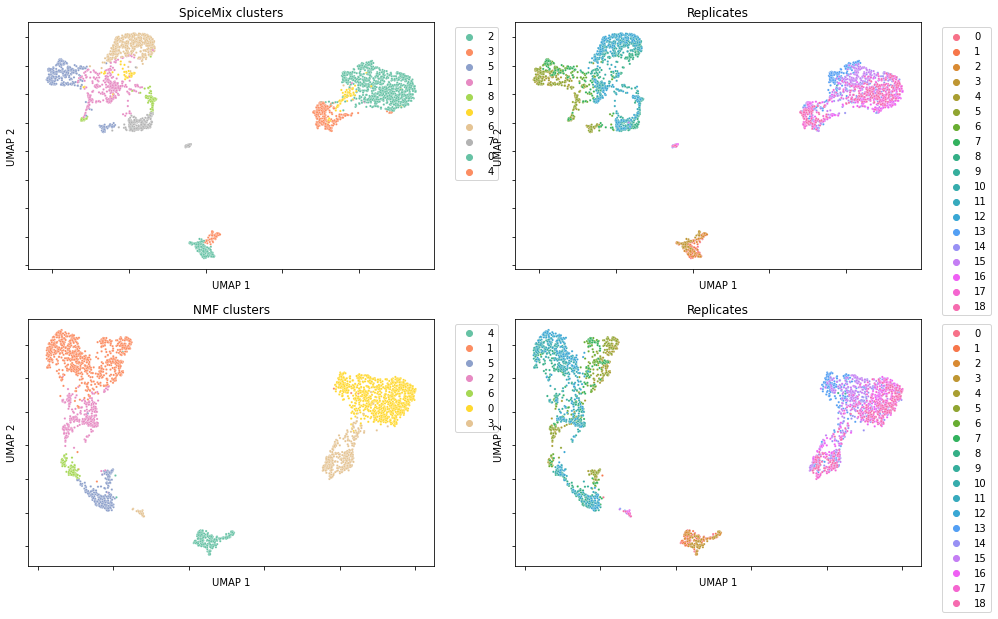

In [18]:
# Visualize cells in the latent space colored by
#   SpiceMix/NMF clusters (cluster)
#   cell types from the original analysis (cell type)
#   replicates (repli)
# Result.visualizeFeaturesSpace is a wraper of Result.visualizeFeatureSpace and handles the custom order of metagenes
kwargs = dict(s=5)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
cardiac_development_spatial_result.plot_feature(axes[0, 0], 'cluster', key_x='UMAP 1', key_y='UMAP 2', **kwargs)
cardiac_development_spatial_result.plot_feature(axes[0, 1], 'replicate', key_x='UMAP 1', key_y='UMAP 2', **kwargs)

cardiac_development_nmf_result.plot_feature(axes[1, 0], 'cluster', key_x='UMAP 1', key_y='UMAP 2', **kwargs)
cardiac_development_nmf_result.plot_feature(axes[1, 1], 'replicate', key_x='UMAP 1', key_y='UMAP 2', **kwargs)

axes[0, 0].set_title('SpiceMix clusters')
axes[0, 1].set_title('Replicates')
axes[1, 0].set_title('NMF clusters')
axes[1, 1].set_title('Replicates')

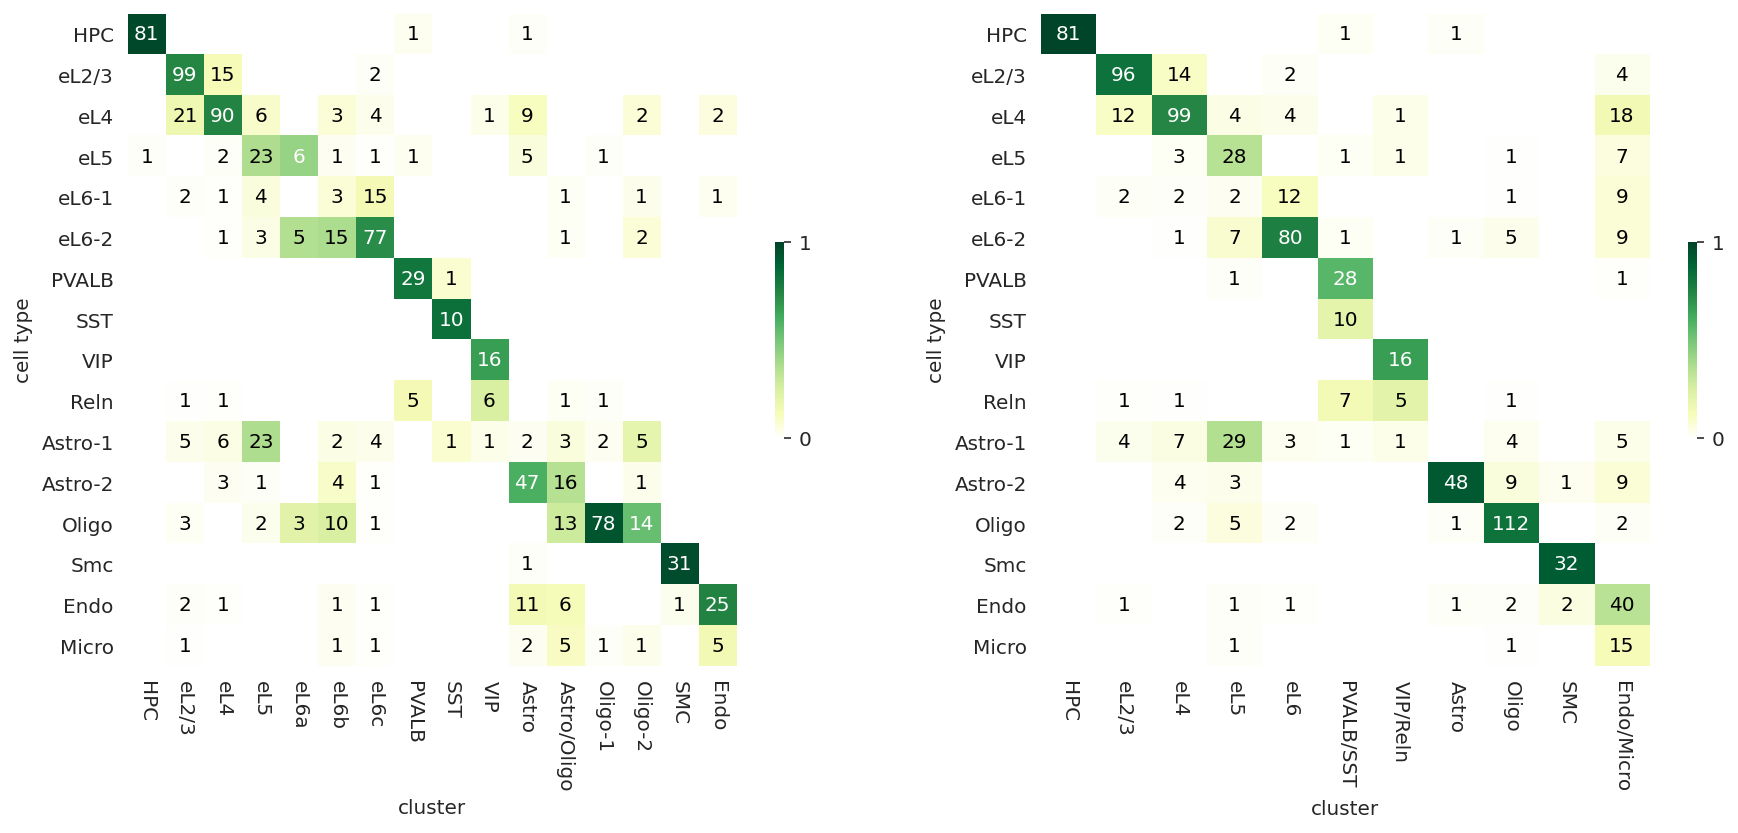

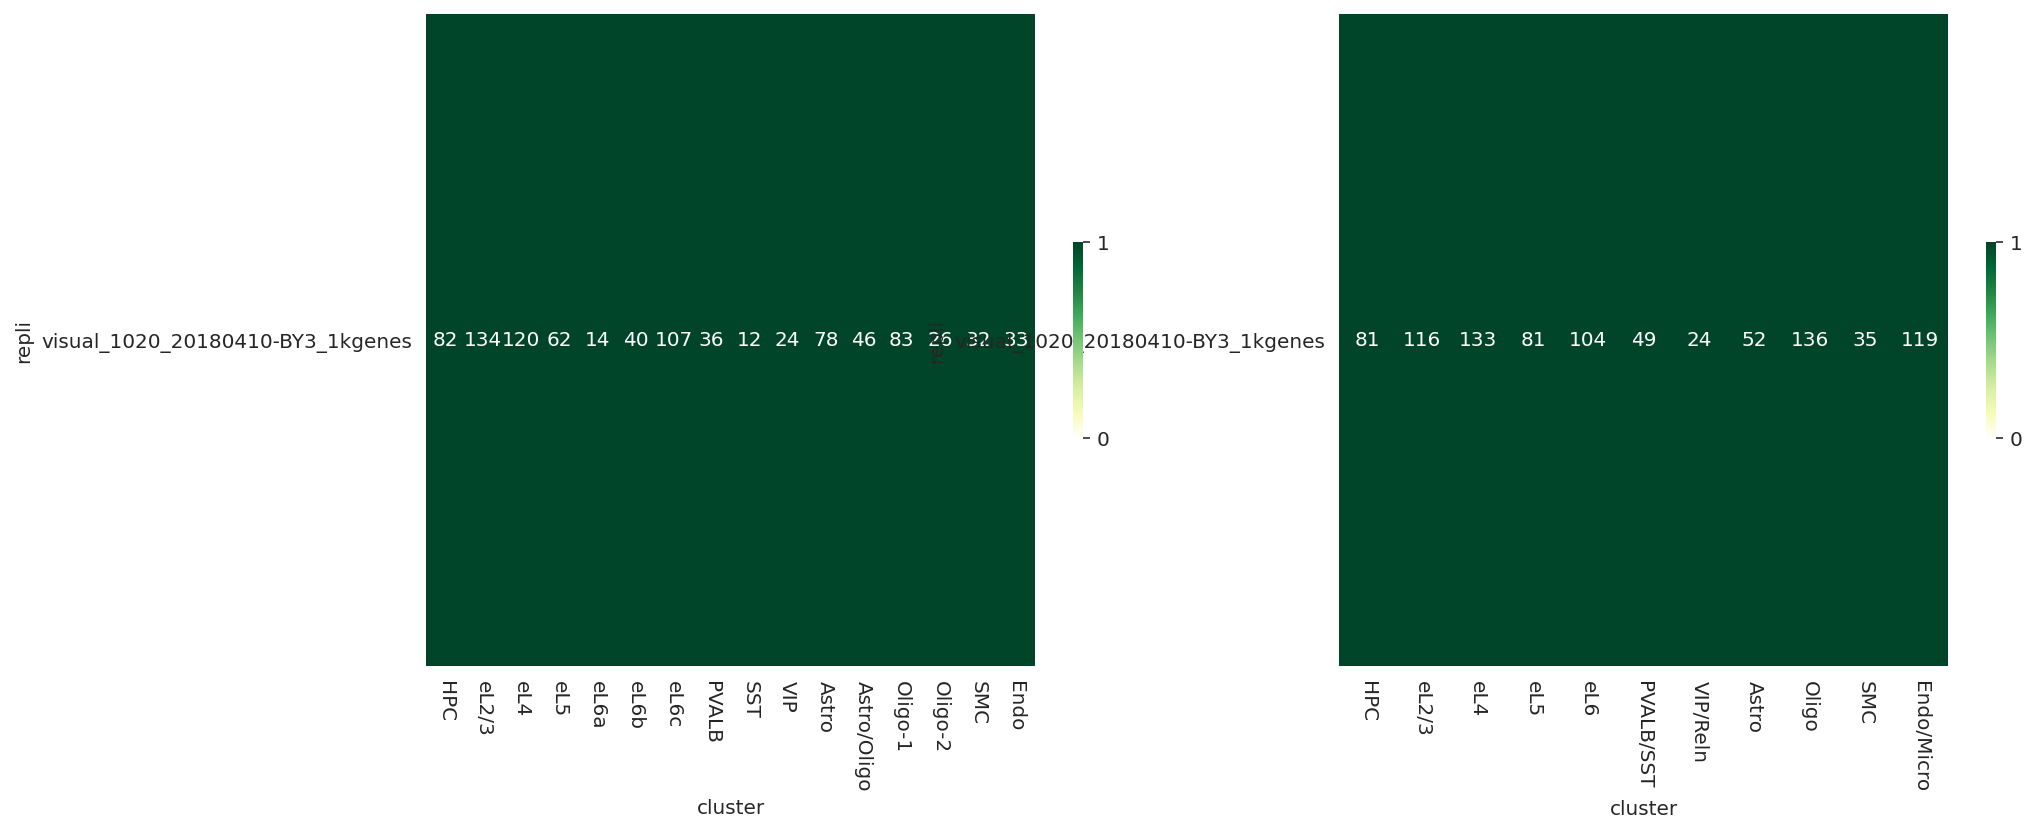

In [13]:
segmentdata = copy.deepcopy(plt.get_cmap('YlGn')._segmentdata)
segmentdata['red'  ][0] = (0., 1., 1.)
segmentdata['green'][0] = (0., 1., 1.)
segmentdata['blue' ][0] = (0., 1., 1.)
cm = matplotlib.colors.LinearSegmentedColormap('', segmentdata=segmentdata, N=256)
kwargs = dict(
    cmap=cm,
)

# compare SpiceMix/NMF clusters with the cell types from the original analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
obj_SpiceMix.visualizeLabelEnrichment(axes[0], **kwargs, ignores_x={'NA'})
obj_NMF     .visualizeLabelEnrichment(axes[1], **kwargs)

# the distribution of SpiceMix/NMF clusters in different replicates
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
obj_SpiceMix.visualizeLabelEnrichment(axes[0], **kwargs, key_x='cluster', key_y='repli', ignores_x={'NA'})
obj_NMF     .visualizeLabelEnrichment(axes[1], **kwargs, key_x='cluster', key_y='repli')

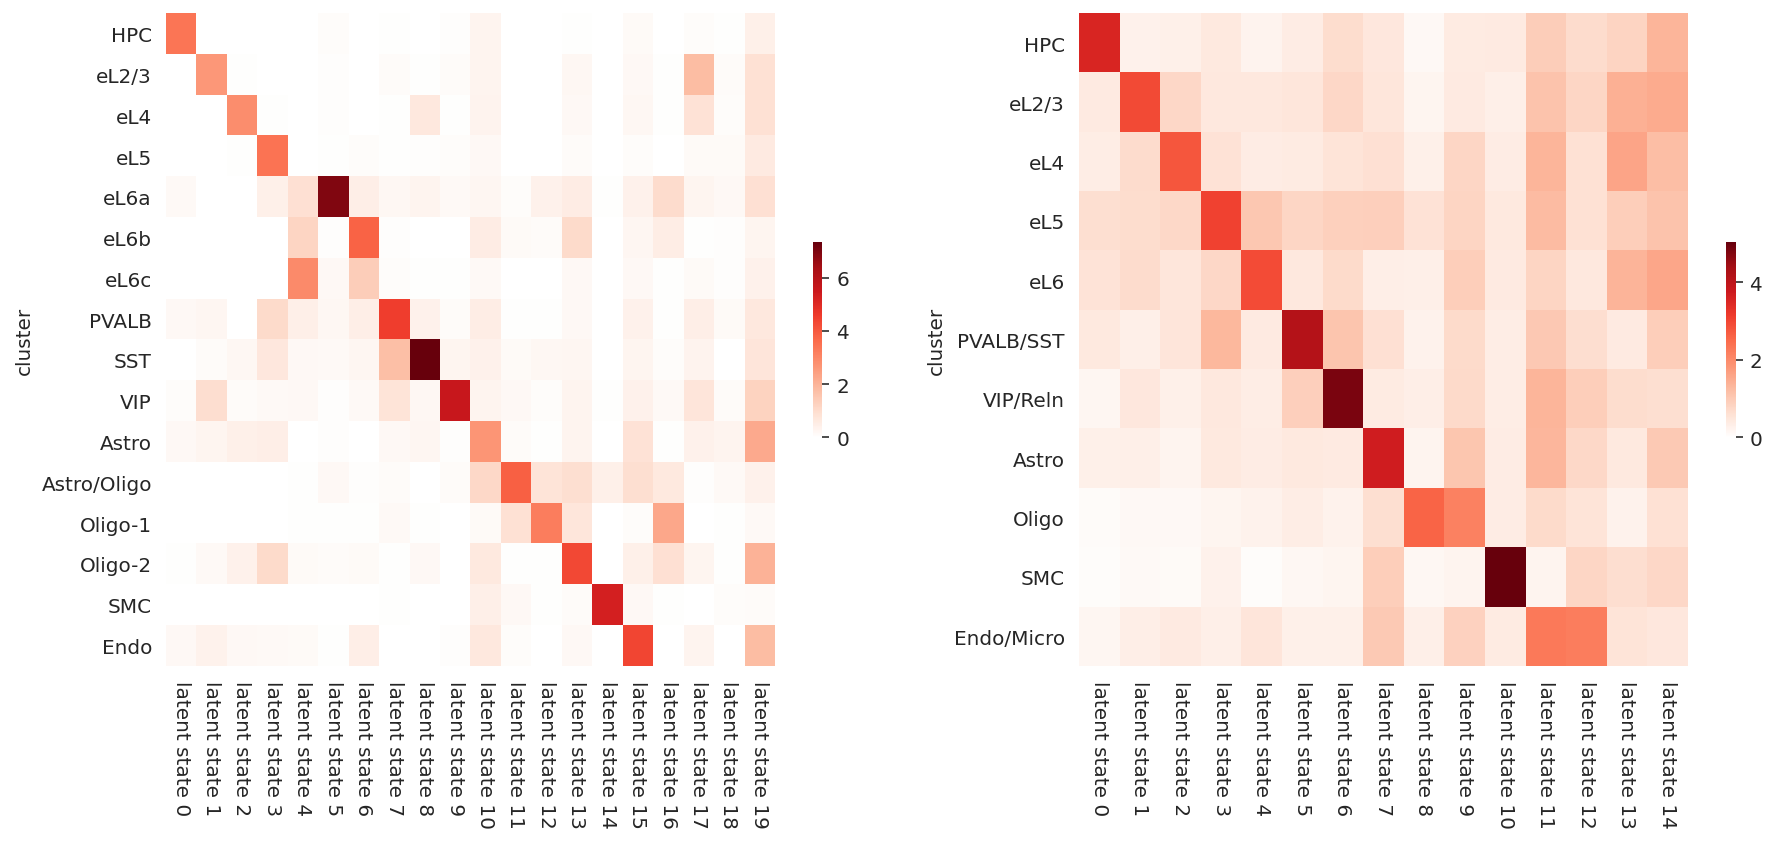

In [14]:
segmentdata = copy.deepcopy(plt.get_cmap('Reds')._segmentdata)
segmentdata['red'  ][0] = (0., 1., 1.)
segmentdata['green'][0] = (0., 1., 1.)
segmentdata['blue' ][0] = (0., 1., 1.)
cm = matplotlib.colors.LinearSegmentedColormap('', segmentdata=segmentdata, N=256)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
obj_SpiceMix.visualizeFeatureEnrichment(
    axes[0], cmap=cm, ignores_y=['NA'],
    normalizer_raw=StandardScaler(with_mean=False).fit_transform,
)
obj_NMF     .visualizeFeatureEnrichment(
    axes[1], cmap=cm,
    normalizer_raw=StandardScaler(with_mean=False).fit_transform,
)

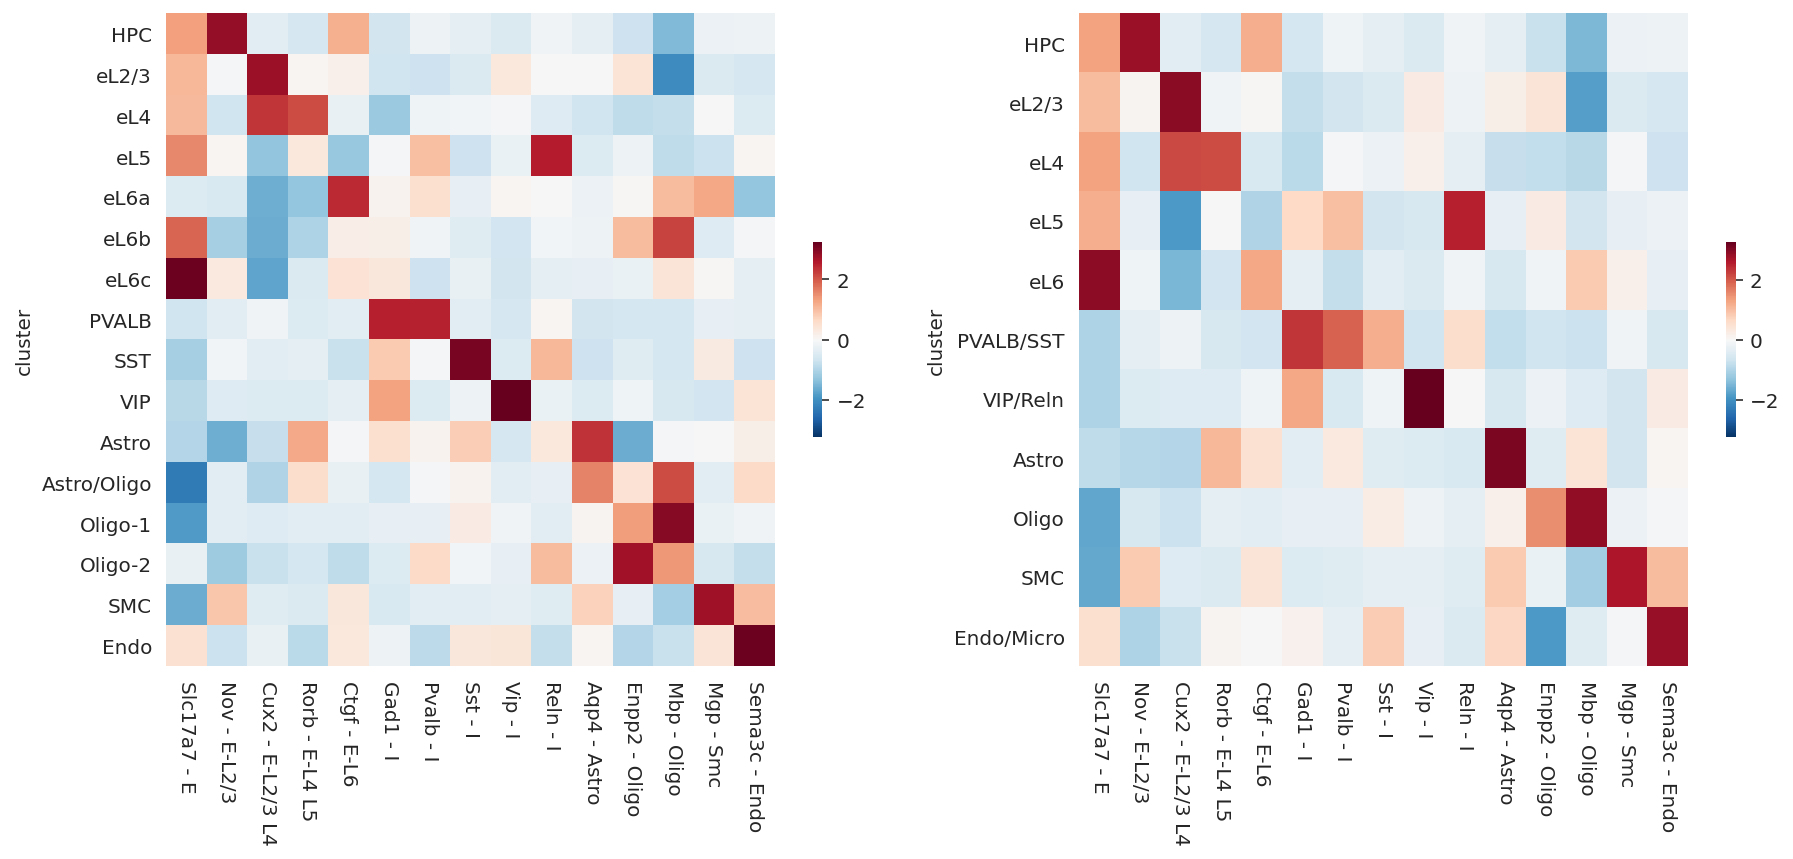

In [15]:
segmentdata = copy.deepcopy(plt.get_cmap('RdBu')._segmentdata)
for key in ['red', 'green', 'blue']:
    segmentdata[key] = [(1.-i, k, j) for (i, j, k) in segmentdata[key][::-1]]
cm = matplotlib.colors.LinearSegmentedColormap('', segmentdata=segmentdata, N=256)
kwargs=dict(
    cmap=cm,
)

# In the first column are the gene IDs, and in the second column are annotations, 
#   which are cell types in this example
gene_list_plot = np.array([
    ('Slc17a7',	'E'), # putative marker of all excitatory neural types
    ('Nov',		'E-L2/3'), # STARmap, Fig. 2J
    ('Cux2',	'E-L2/3 L4'), # STARmap, Fig. 2J
    ('Rorb',	'E-L4 L5'), # STARmap, Fig. 2J
    ('Ctgf',	'E-L6'), # STARmap, Fig. 2J & tasic
    
    ('Gad1',	'I'), # putative marker of all inhibitory neural types
    ('Pvalb',	'I'), # putative marker of PVALB subtype
    ('Sst',		'I'), # putative marker of SST subtype
    ('Vip',		'I'), # putative marker of VIP subtype
    ('Reln',	'I'),
    
    ('Aqp4',	'Astro'), # tasic
    ('Enpp2',	'Oligo'), # STARmap Fig. S6B
    ('Mbp',		'Oligo'), # tasic
    ('Mgp',		'Smc'), # STARmap Fig. S6B
    ('Sema3c',	'Endo'), # STARmap Fig. S6B
])
# Extract gene IDs and prepend string 'expr '
keys_x = [f'expr {_[0]}' for _ in gene_list_plot]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
obj_SpiceMix.visualizeFeatureEnrichment(
    axes[0], keys_x=keys_x, **kwargs, ignores_y=['NA'],
    normalizer_raw=StandardScaler().fit_transform,
    normalizer_avg=lambda x: StandardScaler().fit_transform(x.T).T,
)
obj_NMF     .visualizeFeatureEnrichment(
    axes[1], keys_x=keys_x, **kwargs,
    normalizer_raw=StandardScaler().fit_transform,
    normalizer_avg=lambda x: StandardScaler().fit_transform(x.T).T,
)
for ax in axes:
    ax.set_xticklabels(' - '.join(_) for _ in gene_list_plot)

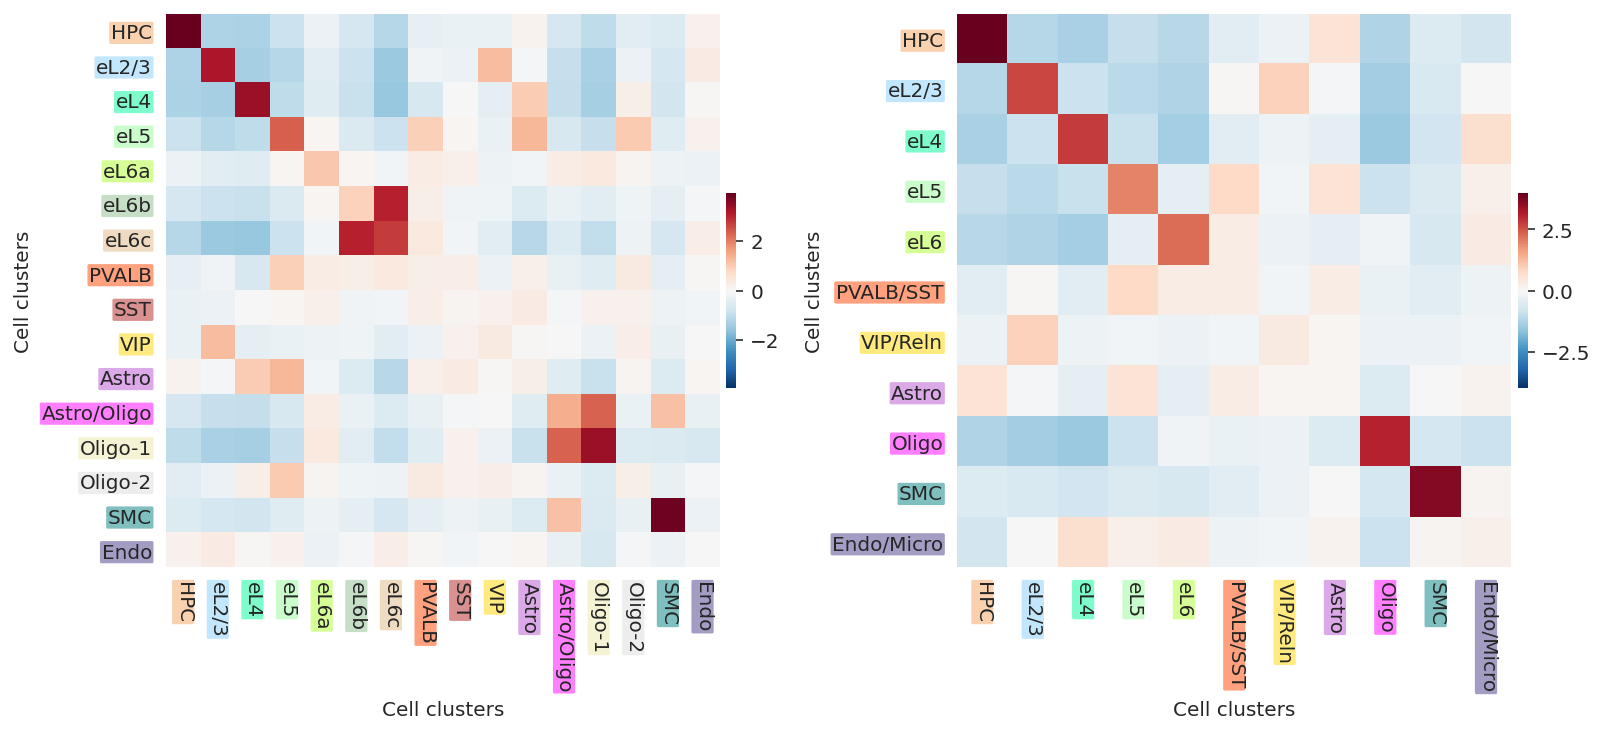

In [16]:
# plot the empirical affinity between cell types
segmentdata = copy.deepcopy(plt.get_cmap('RdBu')._segmentdata)
for channel in ['red', 'green', 'blue']:
    segmentdata[channel] = [(1.-i, k, j) for (i, j, k) in segmentdata[channel][::-1]]
cm = matplotlib.colors.LinearSegmentedColormap('', segmentdata=segmentdata, N=256)
kwargs = dict(
    cmap=cm,
)
fig, axes = plt.subplots(1, 2, figsize=(13, 6))
obj_SpiceMix.plotAffinityClusters(axes[0], ignores={'NA'}, **kwargs)
obj_NMF     .plotAffinityClusters(axes[1], ignores={'NA'}, **kwargs)

Iteration 200
Iteration 200


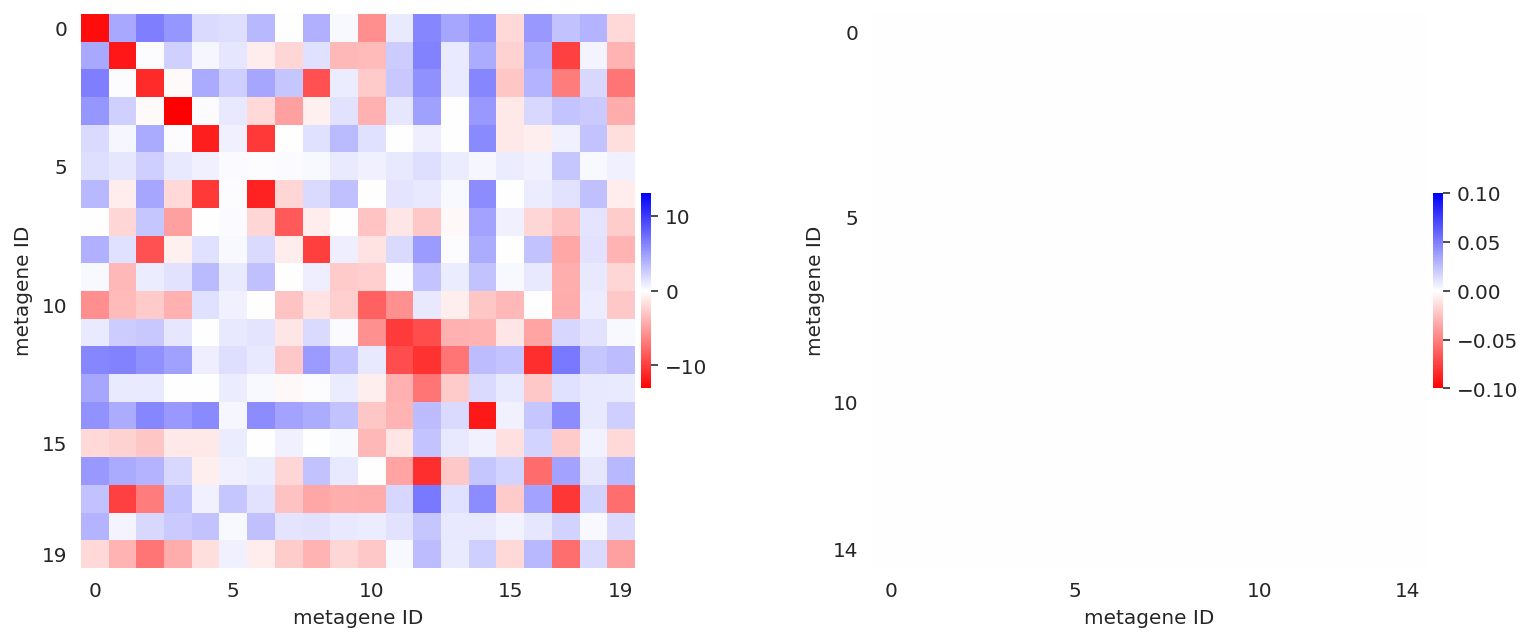

In [17]:
segmentdata = copy.deepcopy(plt.get_cmap('bwr')._segmentdata)
for key in ['red', 'green', 'blue']:
    segmentdata[key] = [(1.-i, k, j) for (i, j, k) in segmentdata[key][::-1]]
cm = matplotlib.colors.LinearSegmentedColormap('', segmentdata=segmentdata, N=256)
kwargs = dict(
    cmap=cm,
)

fig, axes = plt.subplots(1, 2, figsize=(13, 6))
obj_SpiceMix.plotAffinityMetagenes(axes[0], iteration=-1, **kwargs)